Aurora Shop Location Prediction Model

1. Loading data...
Kyiv data shape (after boundary filter): (994, 70)
Lviv data shape (after boundary filter): (172, 70)
Aurora shops in Kyiv: 116
Aurora shops in Lviv: 17.0

2. Exploring data...

Kyiv Data Exploration:
Class distribution:
has_aurora
0    878
1    116
Name: count, dtype: int64
Class balance: 11.67% positive

Top differentiating features:
  variety_store_count: 13524.1% difference
  pawnbroker_count: 7923.1% difference
  eko_market_count: 3936.8% difference
  butcher_count: 2990.7% difference
  greengrocer_count: 2675.3% difference
  vending_machine_count: 2430.9% difference
  bakery_count: 2309.7% difference
  confectionery_count: 2215.2% difference
  chemist_count: 2151.8% difference
  alcohol_count: 2076.1% difference

Lviv Data Exploration:
Class distribution:
has_aurora
0.0    155
1.0     17
Name: count, dtype: int64
Class balance: 9.88% positive

Top differentiating features:
  yes_count: 2483.3% difference
  jewelry_count: 2

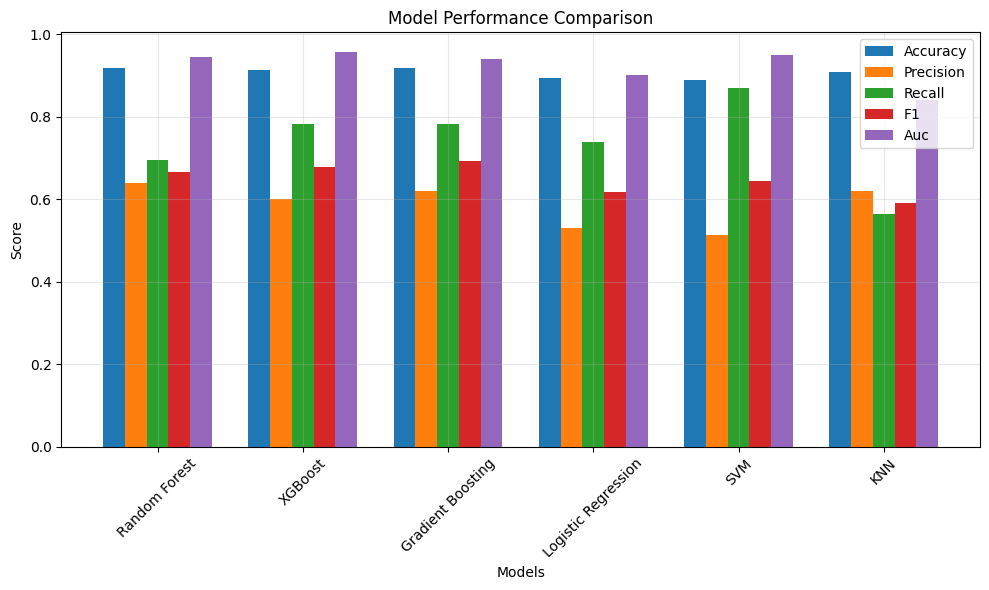


Best model (by F1-score): Gradient Boosting

6. Evaluating Gradient Boosting on Lviv test data...

Test Results (Lviv):
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       155
         1.0       0.43      0.76      0.55        17

    accuracy                           0.88       172
   macro avg       0.70      0.83      0.74       172
weighted avg       0.92      0.88      0.89       172


7. Analyzing feature importance...


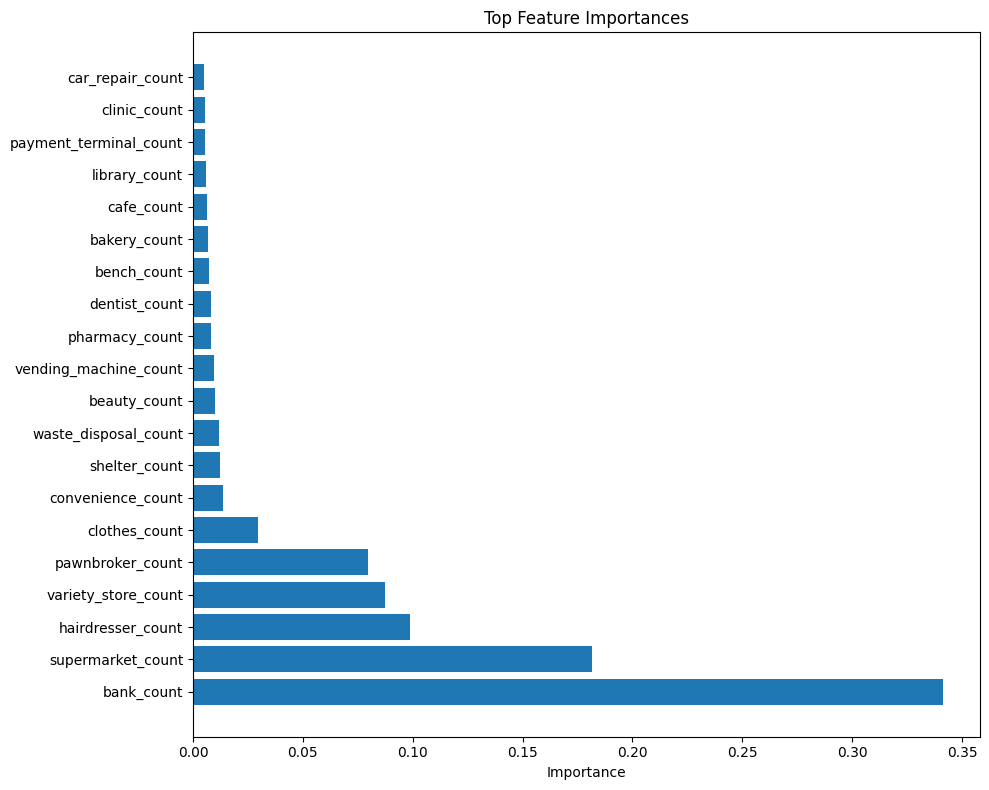


Top 20 most important features:
  bank_count: 0.3411
  supermarket_count: 0.1814
  hairdresser_count: 0.0986
  variety_store_count: 0.0876
  pawnbroker_count: 0.0795
  clothes_count: 0.0296
  convenience_count: 0.0138
  shelter_count: 0.0125
  waste_disposal_count: 0.0120
  beauty_count: 0.0102
  vending_machine_count: 0.0097
  pharmacy_count: 0.0084
  dentist_count: 0.0081
  bench_count: 0.0073
  bakery_count: 0.0067
  cafe_count: 0.0062
  library_count: 0.0059
  payment_terminal_count: 0.0056
  clinic_count: 0.0055
  car_repair_count: 0.0052

8. Predicting best locations for new shops...

Kyiv recommendations:

Top 20 recommended locations for new Aurora shops:
Cell: 881e63b95dfffff, Probability: 0.265
Cell: 881e6385a9fffff, Probability: 0.211
Cell: 881e638ec1fffff, Probability: 0.188
Cell: 881e63bacbfffff, Probability: 0.161
Cell: 881e63b357fffff, Probability: 0.150
Cell: 881e6385c9fffff, Probability: 0.145
Cell: 881e638517fffff, Probability: 0.143
Cell: 881e63b351fffff, Probabilit

In [4]:
#!/usr/bin/env python3
"""
Aurora Shop Location Prediction Model
=====================================
This notebook trains ML models to predict optimal locations for Aurora shops.
Training data: Kyiv
Validation data: Lviv
"""

import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Database connection parameters - UPDATE THESE
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'osm',
    'user': 'postgres',
    'password': 'postpass'
}

# Create connection string
conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Feature columns (excluding id, cell, has_aurora)
FEATURE_COLUMNS = [
    'bench_count', 'cafe_count', 'pharmacy_count', 'waste_disposal_count', 
    'atm_count', 'post_office_count', 'bank_count', 'restaurant_count', 
    'waste_basket_count', 'fuel_count', 'shelter_count', 'toilets_count', 
    'fast_food_count', 'place_of_worship_count', 'bicycle_parking_count', 
    'parking_count', 'bar_count', 'dentist_count', 'drinking_water_count', 
    'clinic_count', 'car_wash_count', 'payment_terminal_count', 'recycling_count', 
    'library_count', 'school_count', 'community_centre_count', 'vending_machine_count', 
    'pub_count', 'bureau_de_change_count', 'doctors_count', 'convenience_count', 
    'clothes_count', 'supermarket_count', 'hairdresser_count', 'yes_count', 
    'car_repair_count', 'beauty_count', 'hardware_count', 'alcohol_count', 
    'car_parts_count', 'butcher_count', 'chemist_count', 'bakery_count', 
    'mobile_phone_count', 'electronics_count', 'doityourself_count', 
    'furniture_count', 'florist_count', 'kiosk_count', 'pawnbroker_count', 
    'pet_count', 'shoes_count', 'confectionery_count', 'optician_count', 
    'cosmetics_count', 'jewelry_count', 'general_count', 'travel_agency_count', 
    'variety_store_count', 'greengrocer_count', 'atb_count', 'novus_count', 
    'eko_market_count', 'fora_count'
]

def load_data(conn_string):
    """Load data from PostgreSQL database"""
    engine = create_engine(conn_string)
    
    # Load Kyiv data
    query_kyiv = """
    SELECT * FROM osm_loc_alike_kyiv
    WHERE boundary_effect = 0  -- Filter out locations very close to existing shops
    """
    df_kyiv = pd.read_sql(query_kyiv, engine)
    
    # Load Lviv data
    query_lviv = """
    SELECT * FROM osm_loc_alike_lviv
    WHERE boundary_effect = 0  -- Filter out locations very close to existing shops
    """
    df_lviv = pd.read_sql(query_lviv, engine)
    
    print(f"Kyiv data shape (after boundary filter): {df_kyiv.shape}")
    print(f"Lviv data shape (after boundary filter): {df_lviv.shape}")
    print(f"Aurora shops in Kyiv: {df_kyiv['has_aurora'].sum()}")
    print(f"Aurora shops in Lviv: {df_lviv['has_aurora'].sum()}")
    
    return df_kyiv, df_lviv

def explore_data(df, city_name):
    """Explore data distribution and patterns"""
    print(f"\n{city_name} Data Exploration:")
    print("="*50)
    
    # Class distribution
    print(f"Class distribution:\n{df['has_aurora'].value_counts()}")
    print(f"Class balance: {df['has_aurora'].sum() / len(df) * 100:.2f}% positive")
    
    # Missing values
    missing = df[FEATURE_COLUMNS].isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:\n{missing[missing > 0]}")
    
    # Feature statistics for shops vs non-shops
    shop_mask = df['has_aurora'] == 1
    
    df.drop('aurora_count', axis=1, inplace=True)
    
    # Select top features by difference
    feature_diffs = {}
    for col in FEATURE_COLUMNS:
        if col in df.columns:
            shop_mean = df.loc[shop_mask, col].mean()
            no_shop_mean = df.loc[~shop_mask, col].mean()
            if no_shop_mean > 0:
                feature_diffs[col] = abs(shop_mean - no_shop_mean) / no_shop_mean
    
    top_features = sorted(feature_diffs.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop differentiating features:")
    for feat, diff in top_features:
        print(f"  {feat}: {diff*100:.1f}% difference")

def prepare_features(df, feature_cols):
    """Prepare feature matrix and handle missing values"""
    # Get available features
    available_features = [col for col in feature_cols if col in df.columns]
    
    X = df[available_features].copy()
    y = df['has_aurora'].copy()
    
    # Handle missing values
    X = X.fillna(0)
    
    return X, y, available_features

def train_models(X_train, y_train, X_test, y_test):
    """Train multiple models and compare performance"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=len(y_train)/y_train.sum()),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Standardize features for some models
        if name in ['Logistic Regression', 'SVM', 'KNN']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
        }
        
        print(f"  Accuracy: {results[name]['accuracy']:.3f}")
        print(f"  Precision: {results[name]['precision']:.3f}")
        print(f"  Recall: {results[name]['recall']:.3f}")
        print(f"  F1-Score: {results[name]['f1']:.3f}")
        print(f"  AUC: {results[name]['auc']:.3f}")
    
    return results

def plot_model_comparison(results):
    """Plot model performance comparison"""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    model_names = list(results.keys())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(model_names))
    width = 0.15
    
    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in model_names]
        ax.bar(x + i*width, values, width, label=metric.capitalize())
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names, top_n=20):
    """Analyze and plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        return
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(10, 8))
    plt.title("Top Feature Importances")
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\nTop {top_n} most important features:")
    for i in indices:
        print(f"  {feature_names[i]}: {importances[i]:.4f}")

def predict_new_locations(model, df, feature_cols, top_n=20):
    """Predict probabilities for locations without Aurora shops"""
    # Filter locations without shops
    no_shop_mask = (df['has_aurora'] == 0) & (df['boundary_effect'] == 0)
    df_potential = df[no_shop_mask].copy()
    
    if len(df_potential) == 0:
        print("No potential locations found")
        return None
    
    # Prepare features
    X_potential = df_potential[feature_cols].fillna(0)
    
    # Predict probabilities
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_potential)[:, 1]
    else:
        # For models without predict_proba, use decision function
        probabilities = model.decision_function(X_potential)
        # Normalize to [0, 1]
        probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    
    df_potential['aurora_probability'] = probabilities
    
    # Get top locations
    top_locations = df_potential.nlargest(top_n, 'aurora_probability')[['cell', 'aurora_probability'] + feature_cols[:10]]
    
    print(f"\nTop {top_n} recommended locations for new Aurora shops:")
    print("="*60)
    for idx, row in top_locations.iterrows():
        print(f"Cell: {row['cell']}, Probability: {row['aurora_probability']:.3f}")
    
    return top_locations

def main():
    """Main execution function"""
    print("Aurora Shop Location Prediction Model")
    print("="*50)
    
    # Load data
    print("\n1. Loading data...")
    df_kyiv, df_lviv = load_data(conn_string)
    
    # Explore data
    print("\n2. Exploring data...")
    explore_data(df_kyiv, "Kyiv")
    explore_data(df_lviv, "Lviv")
    
    # Prepare features
    print("\n3. Preparing features...")
    X_kyiv, y_kyiv, feature_cols = prepare_features(df_kyiv, FEATURE_COLUMNS)
    X_lviv, y_lviv, _ = prepare_features(df_lviv, FEATURE_COLUMNS)
    
    # Split Kyiv data for training/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_kyiv, y_kyiv, test_size=0.2, random_state=42, stratify=y_kyiv
    )
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set (Lviv) size: {len(X_lviv)}")
    
    # Train models
    print("\n4. Training models on Kyiv data...")
    results_val = train_models(X_train, y_train, X_val, y_val)
    
    # Plot comparison
    print("\n5. Comparing model performance...")
    plot_model_comparison(results_val)
    
    # Select best model
    best_model_name = max(results_val.items(), key=lambda x: x[1]['f1'])[0]
    print(f"\nBest model (by F1-score): {best_model_name}")
    
    # Retrain best model on full Kyiv data
    best_model_type = type(results_val[best_model_name]['model'])
    if best_model_name == 'Random Forest':
        best_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    elif best_model_name == 'XGBoost':
        best_model = xgb.XGBClassifier(n_estimators=200, random_state=42, scale_pos_weight=len(y_kyiv)/y_kyiv.sum())
    else:
        best_model = results_val[best_model_name]['model']
    
    # Standardize if necessary
    if best_model_name in ['Logistic Regression', 'SVM', 'KNN']:
        scaler = StandardScaler()
        X_kyiv_scaled = scaler.fit_transform(X_kyiv)
        X_lviv_scaled = scaler.transform(X_lviv)
        best_model.fit(X_kyiv_scaled, y_kyiv)
        X_lviv_final = X_lviv_scaled
    else:
        best_model.fit(X_kyiv, y_kyiv)
        X_lviv_final = X_lviv
    
    # Evaluate on Lviv
    print(f"\n6. Evaluating {best_model_name} on Lviv test data...")
    y_pred_lviv = best_model.predict(X_lviv_final)
    y_pred_proba_lviv = best_model.predict_proba(X_lviv_final)[:, 1]
    
    print("\nTest Results (Lviv):")
    print(classification_report(y_lviv, y_pred_lviv))
    
    # Feature importance
    print("\n7. Analyzing feature importance...")
    analyze_feature_importance(best_model, feature_cols)
    
    # Predict new locations
    print("\n8. Predicting best locations for new shops...")
    print("\nKyiv recommendations:")
    predict_new_locations(best_model, df_kyiv, feature_cols)
    
    print("\nLviv recommendations:")
    predict_new_locations(best_model, df_lviv, feature_cols)
    
    # Save model
    print("\n9. Saving model...")
    import joblib
    joblib.dump(best_model, 'aurora_location_model.pkl')
    if best_model_name in ['Logistic Regression', 'SVM', 'KNN']:
        joblib.dump(scaler, 'aurora_location_scaler.pkl')
    print("Model saved successfully!")
    
    return best_model, results_val

model, results = main()